# **Skin Cancer Classification CNN Analysis**

##**Importing the Libraries Required**

In [1]:
import torch
from torch import nn, optim
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import pyarrow.parquet as pq
import pandas as pd
import io
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Setting Library Seeds for Reproducibility**

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

##**Preparing the Dataset**

In [5]:
!unzip -oq /content/drive/MyDrive/cancer_dataset.zip

##**Implementing a Custom Dataset**



In [6]:
class CancerDataset(Dataset):
    def __init__(self, parquet_file):
        """
        Args:
            parquet_file (str): Path to the Parquet file containing the dataset.
                                The dataset should have two columns: 'bytes' (image data) and 'label'.
        """
        data = pd.read_parquet(parquet_file).values

        self.image_bytes_list = [entry[0]['bytes'] if isinstance(entry[0], dict) else entry[0] for entry in data]
        self.class_list = [entry[1] for entry in data]

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.image_bytes_list)

    def __getitem__(self, data_id):
        """
        Fetches the image and label for a given index.
        """
        image_bytes = self.image_bytes_list[data_id]
        image_class = self.class_list[data_id]

        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        image_tensor = self.transform(image)

        return image_class, image_tensor

In [7]:
train_dataset = CancerDataset("/content/balanced_skin_cancer_dataset_train_2.parquet")
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_ratio = 0.125
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
val_dataloader = DataLoader(val_subset, batch_size=128, shuffle=False)

test_dataset = CancerDataset("/content/balanced_skin_cancer_dataset_test.parquet")
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

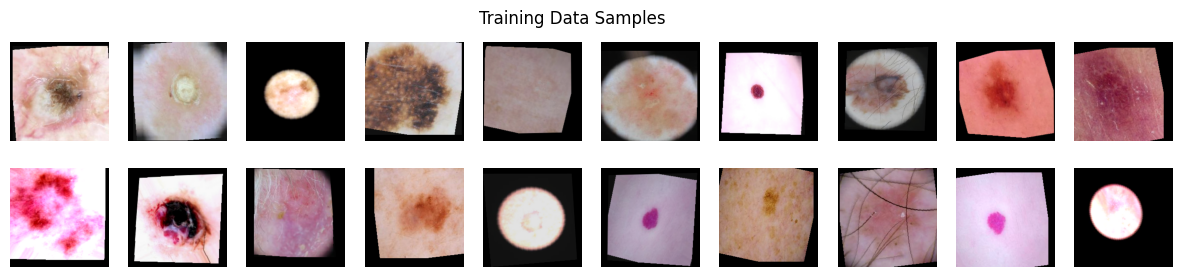

In [8]:
_, images = next(iter(train_dataloader))
images = images.numpy()

num_rows = 2
num_columns = 10

figure, axis_array = plt.subplots(num_rows, num_columns, figsize=(num_columns*1.5,num_rows*1.5))
figure.suptitle("Training Data Samples")

im_id = 0
for row_id in range(num_rows):
  for column_id in range(num_columns):
    # The channel dimension of the image is moved to the last index
    # to make the shape of the image compatible with Matplotlib
    image = images[im_id].transpose(1,2,0)
    # Value range is mapped from [-1,1] to [0,1]
    image = (image + 1) / 2
    if num_rows == 1:
      current_axis = axis_array[column_id]
    else:
      current_axis = axis_array[row_id, column_id]
    current_axis.axis('off')
    current_axis.imshow(image)
    im_id += 1

##**Constructing a Classifier Network**

In [9]:
class CancerClassifier(nn.Module):
    def __init__(self):
        super(CancerClassifier, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x112x112
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64x56x56
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128x28x28
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256x14x14
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=50176, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=8)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.flatten(x)
        x = self.fc_layers(x)

        return x

##**Implementing the Training Loop**


In [10]:
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CancerClassifier().to(device)
optimizer = Adam(model.parameters(), lr=2e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
patience_counter = 0
patience_limit = 10

In [11]:
num_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)
num_epochs = 400

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_image_class, batch_image_tensor in train_dataloader:
        batch_image_tensor, batch_image_class = batch_image_tensor.to(device), batch_image_class.to(device)
        optimizer.zero_grad()
        outputs = model(batch_image_tensor)
        loss = loss_func(outputs, batch_image_class)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / num_batches
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_image_class, val_image_tensor in val_dataloader:
            val_image_tensor, val_image_class = val_image_tensor.to(device), val_image_class.to(device)
            val_outputs = model(val_image_tensor)
            val_loss = loss_func(val_outputs, val_image_class)
            running_val_loss += val_loss.item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_image_class.size(0)
            correct += (predicted == val_image_class).sum().item()

    avg_val_loss = running_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    scheduler.step(avg_val_loss)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.2f}% - LR: {current_lr:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    if patience_counter >= patience_limit:
        print("Early stopping triggered. Terminating training.")
        break

Epoch 1/400 - Train Loss: 2.0232 - Val Loss: 1.7836 - Val Acc: 31.86% - LR: 0.000200
Epoch 2/400 - Train Loss: 1.8143 - Val Loss: 1.6978 - Val Acc: 37.48% - LR: 0.000200
Epoch 3/400 - Train Loss: 1.7436 - Val Loss: 1.6533 - Val Acc: 35.33% - LR: 0.000200
Epoch 4/400 - Train Loss: 1.6922 - Val Loss: 1.6091 - Val Acc: 38.76% - LR: 0.000200
Epoch 5/400 - Train Loss: 1.6358 - Val Loss: 1.5443 - Val Acc: 40.52% - LR: 0.000200
Epoch 6/400 - Train Loss: 1.5960 - Val Loss: 1.5122 - Val Acc: 42.62% - LR: 0.000200
Epoch 7/400 - Train Loss: 1.5466 - Val Loss: 1.4642 - Val Acc: 44.48% - LR: 0.000200
Epoch 8/400 - Train Loss: 1.5115 - Val Loss: 1.4033 - Val Acc: 45.14% - LR: 0.000200
Epoch 9/400 - Train Loss: 1.4758 - Val Loss: 1.4444 - Val Acc: 46.10% - LR: 0.000200
No improvement for 1 epochs.
Epoch 10/400 - Train Loss: 1.4560 - Val Loss: 1.3614 - Val Acc: 47.14% - LR: 0.000200
Epoch 11/400 - Train Loss: 1.4301 - Val Loss: 1.3374 - Val Acc: 49.19% - LR: 0.000200
Epoch 12/400 - Train Loss: 1.3930 

KeyboardInterrupt: 

##**Plotting the Training Loss Curves**

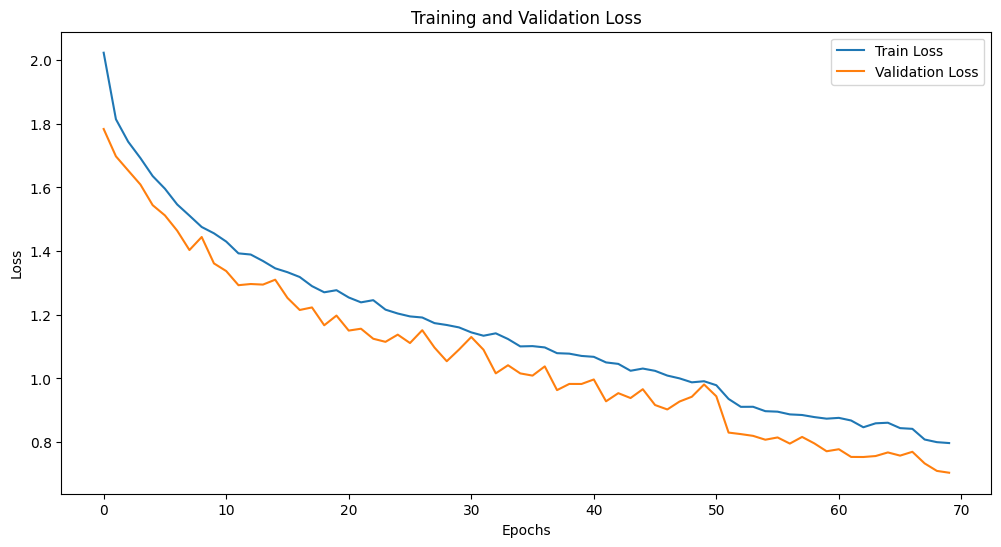

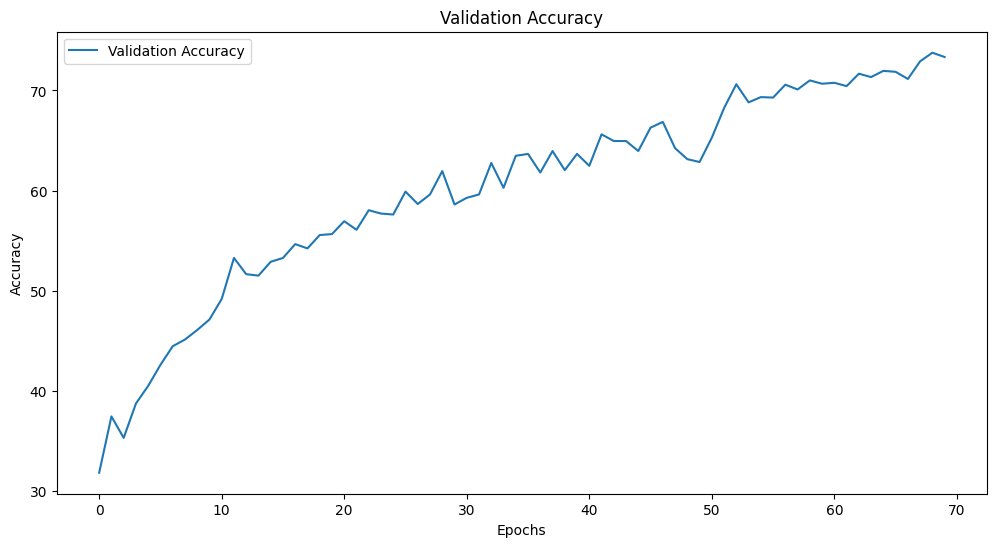

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

##**Evaluating the Model**

In [13]:
model.eval()

pred_class_list = []
gt_class_list = []
test_accuracies = []

with torch.no_grad():
    for batch_image_class, batch_image_tensor in test_dataloader:
        if torch.cuda.is_available():
            batch_image_tensor = batch_image_tensor.cuda()
            batch_image_class = batch_image_class.cuda()

        batch_outputs = model(batch_image_tensor)

        batch_image_class = batch_image_class.cpu().numpy()
        batch_outputs = batch_outputs.cpu().numpy()
        pred_classes = np.argmax(batch_outputs, axis=1)

        pred_class_list.extend(pred_classes)
        gt_class_list.extend(batch_image_class)

In [16]:
# Calculate overall accuracy
accuracy = accuracy_score(gt_class_list, pred_class_list)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(gt_class_list, pred_class_list))

Accuracy: 0.6885
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       524
           1       0.64      0.72      0.67       524
           2       0.50      0.50      0.50       524
           3       0.78      0.96      0.86       524
           4       0.57      0.45      0.50       524
           5       0.64      0.73      0.68       524
           6       0.71      0.56      0.63       524
           7       0.96      0.97      0.97       524

    accuracy                           0.69      4192
   macro avg       0.68      0.69      0.68      4192
weighted avg       0.68      0.69      0.68      4192

